🚀 Starting Advanced ETL Pipeline...
Data loaded into SQL Warehouse.


/var/folders/82/n2wrm9914vn4m3chfl1g9pd80000gn/T/ipykernel_6315/18266688.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Region'].fillna('Unknown', inplace=True)
/var/folders/82/n2wrm9914vn4m3chfl1g9pd80000gn/T/ipykernel_6315/18266688.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_prod, x='Margin_Pct', y='Product', palette='magma', ax=ax_prod)


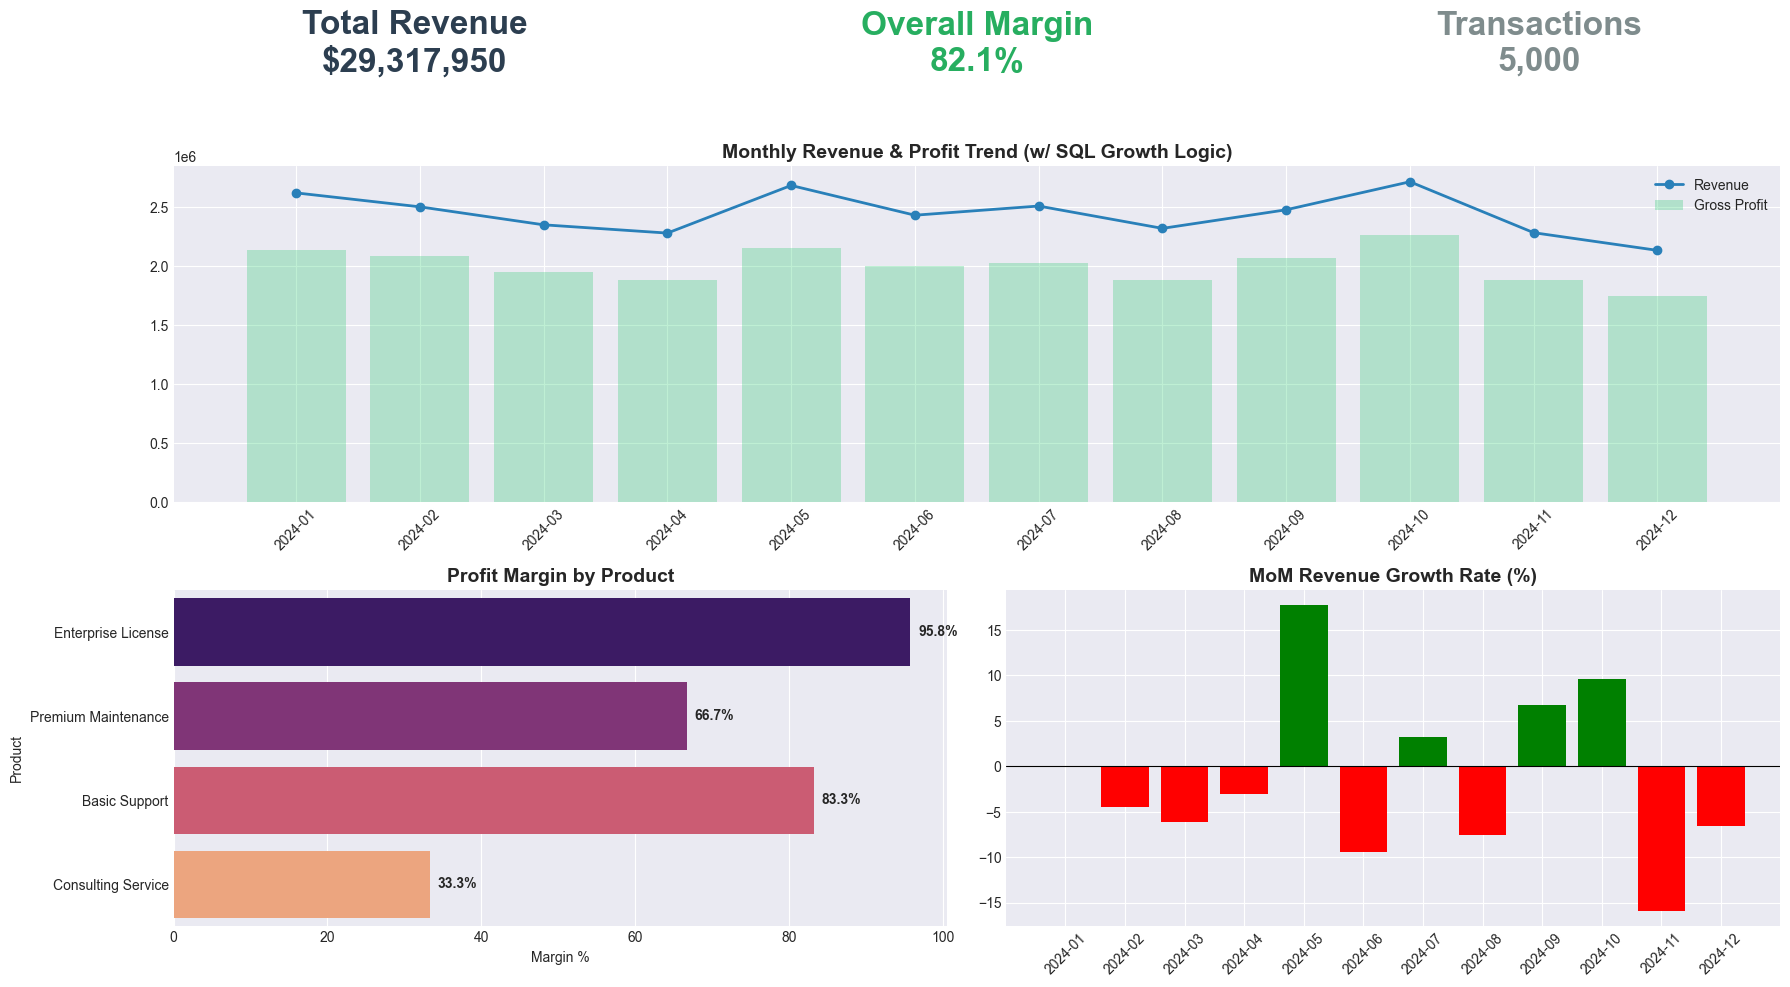

✅ Executive Dashboard generated.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sqlite3

# --- STEP 1: ETL PIPELINE ---
print("🚀 Starting Advanced ETL Pipeline...")
df = pd.read_csv('../data/raw_sales_data.csv')

# Clean & Prep
df['Region'].fillna('Unknown', inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.to_period('M').astype(str) # For SQL grouping

# Financials
df['Total_Revenue'] = df['Quantity'] * df['Unit_Price']
df['Total_Cost'] = df['Quantity'] * df['Unit_Cost']
df['Gross_Profit'] = df['Total_Revenue'] - df['Total_Cost']

# Setup SQL
conn = sqlite3.connect(':memory:')
df.to_sql('sales', conn, index=False, if_exists='replace')

print("Data loaded into SQL Warehouse.")

# --- STEP 2: ADVANCED SQL (The "Pro" Part) ---
# We calculate Month-over-Month (MoM) Growth using Window Functions
query_trend = """
WITH MonthlyStats AS (
    SELECT 
        strftime('%Y-%m', Date) as Month_ID,
        SUM(Total_Revenue) as Revenue,
        SUM(Gross_Profit) as Profit
    FROM sales
    GROUP BY Month_ID
)
SELECT 
    Month_ID,
    Revenue,
    Profit,
    -- Calculate Previous Month Revenue
    LAG(Revenue, 1) OVER (ORDER BY Month_ID) as Prev_Month_Rev,
    -- Calculate Growth Rate
    ROUND((Revenue - LAG(Revenue, 1) OVER (ORDER BY Month_ID)) / LAG(Revenue, 1) OVER (ORDER BY Month_ID) * 100, 2) as Growth_Pct
FROM MonthlyStats
"""
df_trend = pd.read_sql_query(query_trend, conn)

# KPI Query: Products
query_prod = """
SELECT Product, SUM(Total_Revenue) as Rev, SUM(Gross_Profit) as Prof,
ROUND(SUM(Gross_Profit)/SUM(Total_Revenue)*100, 1) as Margin_Pct
FROM sales GROUP BY Product ORDER BY Rev DESC
"""
df_prod = pd.read_sql_query(query_prod, conn)

# --- STEP 3: EXECUTIVE DASHBOARD (Visuals) ---
# Setting a professional style
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.2, 1, 1]) # Header, Trend, Details

# 1. KPI CARDS (Top Row)
ax_kpi = fig.add_subplot(gs[0, :])
ax_kpi.axis('off')
total_rev = df['Total_Revenue'].sum()
total_margin = (df['Gross_Profit'].sum() / total_rev) * 100
ax_kpi.text(0.15, 0.5, f"Total Revenue\n${total_rev:,.0f}", fontsize=24, color='#2c3e50', ha='center', va='center', fontweight='bold')
ax_kpi.text(0.50, 0.5, f"Overall Margin\n{total_margin:.1f}%", fontsize=24, color='#27ae60', ha='center', va='center', fontweight='bold')
ax_kpi.text(0.85, 0.5, f"Transactions\n{len(df):,}", fontsize=24, color='#7f8c8d', ha='center', va='center', fontweight='bold')

# 2. TREND ANALYSIS (Middle Row) - Dual Axis Chart
ax_trend = fig.add_subplot(gs[1, :])
ax_trend.plot(df_trend['Month_ID'], df_trend['Revenue'], marker='o', color='#2980b9', linewidth=2, label='Revenue')
ax_trend.bar(df_trend['Month_ID'], df_trend['Profit'], color='#2ecc71', alpha=0.3, label='Gross Profit')
ax_trend.set_title('Monthly Revenue & Profit Trend (w/ SQL Growth Logic)', fontsize=14, fontweight='bold')
ax_trend.legend()
plt.setp(ax_trend.get_xticklabels(), rotation=45)

# 3. PRODUCT BREAKDOWN (Bottom Left)
ax_prod = fig.add_subplot(gs[2, 0])
sns.barplot(data=df_prod, x='Margin_Pct', y='Product', palette='magma', ax=ax_prod)
ax_prod.set_title('Profit Margin by Product', fontsize=14, fontweight='bold')
ax_prod.set_xlabel('Margin %')
for i, v in enumerate(df_prod['Margin_Pct']):
    ax_prod.text(v + 1, i, str(v)+'%', va='center', fontweight='bold')

# 4. GROWTH ANALYSIS (Bottom Right)
ax_growth = fig.add_subplot(gs[2, 1])
# Color bars green if positive, red if negative
colors = ['red' if x < 0 else 'green' for x in df_trend['Growth_Pct'].fillna(0)]
ax_growth.bar(df_trend['Month_ID'], df_trend['Growth_Pct'].fillna(0), color=colors)
ax_growth.set_title('MoM Revenue Growth Rate (%)', fontsize=14, fontweight='bold')
ax_growth.axhline(0, color='black', linewidth=0.8)
plt.setp(ax_growth.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('dashboard_kpi.png', dpi=300)
plt.show()

print("✅ Executive Dashboard generated.")